# Creating Knowledge Graph for News information

## Graph is generated using NER result from PORORO.
1. Each keyword from PORORO are created as a node 
2. Nodes are connected if the nodes are generated within the same sentence

### Importing necessary packages

In [1]:
import pandas as pd
import networkx as nx
import itertools
import community as community_louvain
import json
from pyvis.network import Network
import pickle
import matplotlib.pyplot as plt
import math

### Reading news data and defining stop words

In [2]:
df_cs = pd.read_pickle('~/data/df_news_final.pickle')

In [ ]:
remove_list = [
    '과장', '관계사', '사장', '상무', '고객', '챗GPT'
]

replace_dict = {
    '폐배터': '폐배터리',
    '배터': '배터리',
    '이차전지': '2차전지',
    # '테스': '테슬라'
}

### Generating graph from the news data

In [3]:
result = []
nodes = dict()
edges = dict()
nodes_info = dict()



for _, row in df_cs.iterrows():
    ner_list = row['ner']
    for ners in ner_list:
        # Loop through ner within sentences
        for i in range(len(ners)):
            pair_1 = ners[i][0]

            if pair_1 in remove_list:
                continue
            if pair_1 in replace_dict:
                pair_1 = replace_dict[pair_1]

            if pair_1 in nodes:
                nodes[pair_1] += 1
            else:
                nodes[pair_1] = 1
            nodes_info[pair_1] = ners[i][1]

            for j in range(i+1, len(ners)):
                pair_2 = ners[j][0]

                if pair_2 in remove_list:
                    continue
                if pair_2 in replace_dict:
                    pair_2 = replace_dict[pair_2]


                if pair_1 == pair_2:
                    continue
                key = frozenset((pair_1, pair_2))
                if key in edges:
                    edges[key] += 1
                else:
                    edges[key] = 1
        

### Retrieve top n nodes based on frequency and edges

In [4]:
def get_top_n_nodes(n, nodes, edges):
    sorted_nodes = {k: v for k, v in sorted(nodes.items(), key=lambda item: item[1], reverse=True)}

    result_nodes = {}
    remove_list = []
    for i, (k,v) in enumerate(sorted_nodes.items()):
        if i < n:
            result_nodes[k] = v
        else:
            for keys in edges.keys():
                if k in keys:
                    remove_list.append(keys)
    result_edges = {k:v for k,v in edges.items() if k not in remove_list}

    return result_nodes, result_edges
    

### Generate Graph using NetworkX

{'배터리': Text(0.10562681966574021, 0.0197193441555544, '배터리'),
 '전기차': Text(-0.013562926283801412, 0.07867564340015551, '전기차'),
 '폐배터리': Text(0.01723556043327671, -0.02738780408266244, '폐배터리'),
 'SK에코플랜트': Text(0.2881869595512288, 0.2231606328320066, 'SK에코플랜트'),
 '2차전지': Text(0.05604707007579049, 0.16889134854311205, '2차전지'),
 '영풍': Text(0.5003363932092542, -0.019512698359646342, '영풍'),
 '성일하이텍': Text(-0.015712054390414173, 0.3080412458775951, '성일하이텍'),
 'LG화학': Text(0.2185012506728806, 0.3784236461978752, 'LG화학'),
 '정부': Text(-0.35824372320700476, -0.020091181615821532, '정부'),
 '드론': Text(0.22568740493557343, 0.4795104682512427, '드론'),
 '테스': Text(0.38919340936190255, -0.13158026233053471, '테스'),
 'ESS': Text(-0.33875719582802133, 0.15028709180847452, 'ESS'),
 '재영텍': Text(0.44063508588378564, -0.34371426525822435, '재영텍'),
 'CNGR': Text(0.5338355453811405, -0.28560956823379885, 'CNGR'),
 '관계자': Text(0.0855826532371498, -0.15079732856972197, '관계자'),
 'SK이노베이션': Text(0.060133641250101684,

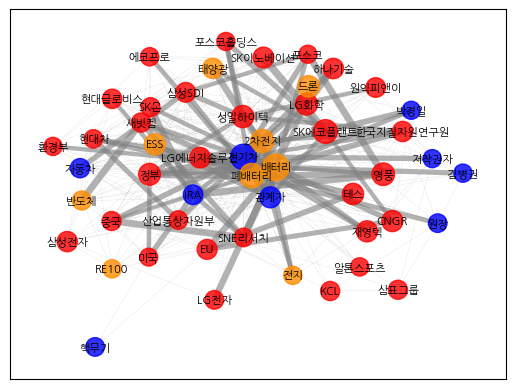

In [13]:
result = get_top_n_nodes(50, nodes, edges)

node_size = [ int(math.log(x) * 50 ) for x in result[0].values()]

color_dict = {
   'ARTIFACT': 'blue', 
   'CIVILIZATION': 'blue', 
   'ORGANIZATION': 'red', 
   'PERSON': 'blue', 
   'TERM': 'darkorange',
}

color_map = [
   color_dict[nodes_info[k]] if nodes_info[k] in color_dict else 'lightgray'
   for k in result[0].keys()
]


edge_width = [ 0.1 if v < 20 else math.log(v) for v in result[1].values()]

G=nx.Graph()
G.add_nodes_from(result[0].keys())
G.add_edges_from(result[1].keys())

pos=nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G,pos,
                       node_size=node_size,
                       node_color=color_map,
                       alpha=0.8)
nx.draw_networkx_edges(G,pos,
                    #    edgelist = widths.keys(),
                       width=edge_width,
                       edge_color='gray',
                       alpha=0.6)
# nx.draw(G, pos, node_color=color_map, node_size=node_size, width=edge_width)

nx.draw_networkx_labels(G,pos, font_family='NanumGothic', font_size=8)


# Creating Knowledge Graph with DART data

## Graph are generated with DART information 
1. Company nodes are generated
2. DART NER keyword nodes are generated
3. The comany node and DART NER nodes are connected with an edge with a property depending on the content

In [92]:
# 데이터 불러오기
data1_path = '/home/kic/data/dart_processed/dict_sector_product.pickle'
data2_path = '/home/kic/data/dart_processed/html_EV_v2.pickle'
ev_list_path = '/home/kic/data/kodex/EV_processed.csv'

with open(data1_path, 'rb') as f:
    data1 = pickle.load(f)

with open(data2_path, 'rb') as f:
    data2 = pickle.load(f)

ev_list = pd.read_csv(ev_list_path, dtype=object)

In [93]:
# 기업명 추가 
# for key in data2.keys():
#     data2[key]['corp_name'] = ev_list.loc[ev_list.corp_code==key, 'corp_name'].values[0]

# with open('/home/kic/data/dart_processed/html_EV_v2.pickle', 'wb') as f:
#     pickle.dump(data2, f)

### 지식그래프 그려보기

In [94]:
g = nx.Graph()

#### 기업명으로 노드 만들기 

In [95]:
corp_name = []
for key in data2.keys():
    corp_name.append(data2[key]['corp_name'])
g.add_nodes_from(corp_name, kind='corporation')

{'삼성SDI': Text(-0.9614600567846889, 0.2902648063632326, '삼성SDI'),
 '후성': Text(-0.7597560371343536, -0.43562194297584916, '후성'),
 '효성첨단소재': Text(-0.9922868939117377, -0.12222196845593447, '효성첨단소재'),
 '화신': Text(0.5372855253377156, 0.7695670095401398, '화신'),
 '현대자동차': Text(0.8062796417475556, 0.5383879396144856, '현대자동차'),
 '현대일렉트릭': Text(0.2764455823566756, -0.905800539118709, '현대일렉트릭'),
 '현대위아': Text(0.9637040959001084, -0.24958025562242794, '현대위아'),
 '현대오토에버': Text(0.3501316069501408, 0.7955312617569206, '현대오토에버'),
 '현대에너지솔루션': Text(-0.5086600330193932, -0.8394463447227067, '현대에너지솔루션'),
 '현대모비스': Text(0.9997015588643735, -0.14443582244936734, '현대모비스'),
 '현대글로비스': Text(0.884653907772747, -0.043373809844953315, '현대글로비스'),
 '해성디에스': Text(0.6772555875230724, 0.6782218523685376, '해성디에스'),
 '한화솔루션': Text(-0.2791464849868193, 0.9854154677112906, '한화솔루션'),
 '한솔케미칼': Text(-0.8696662426017383, -0.1402773461247334, '한솔케미칼'),
 '한국타이어앤테크놀로지': Text(0.6296709858181391, -0.7960530010300569, '한국타이어앤테크놀

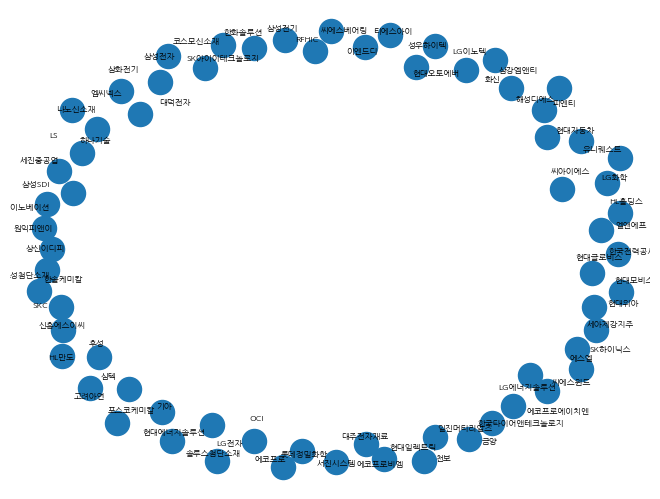

In [96]:
# 그려보기 
pos=nx.spring_layout(g)
nx.draw(g)
nx.draw_networkx_labels(g,pos, font_family='NanumGothic', font_size=6)

#### 주요 제품 추가 

In [97]:
# 노드 생성 
주요제품_level1 = []
for key in data2.keys():
    주요제품_level1 += [product for product in data1[key].keys()]

In [98]:
주요제품_level1

['에너지솔루션',
 '전자재료',
 '기초화합물제조판매 (냉매 外)',
 '산업자재',
 '섬유',
 '기타',
 '자 동 차 부 품',
 '상 품',
 '차량',
 '기타',
 '전 기 전 자 부 문',
 '차량 부품',
 '기계',
 'ITO',
 'SI',
 '차량용 SW',
 '그린 에너지',
 '모듈 및 부품제조',
 'A/S용 부품',
 '반도체 Substrate',
 '기타',
 'LDPE',
 '가성소다, PVC',
 '임대료',
 '-',
 '자동차 부품, 산업용 소재',
 '전자소재, 태양광소재',
 '의류 잡화, 식음료',
 '임대 매출',
 '셀, 모듈',
 '-',
 '자 동 차 관 련',
 '기 타',
 '전기판매',
 '원자력발전',
 '화력발전',
 '기타',
 '이차전지 장비',
 '기타(제품외)',
 '2차전지',
 '소재',
 '별도기준',
 '섬서인과기계설비(유)',
 '(주)나노기술',
 'People & Technology HUNGARY Kft.',
 '내화물',
 '라임화성',
 '에너지소재',
 '기능성필름',
 '토너,NCM, LCO',
 '-',
 '전자소재',
 '이차전지소재',
 '의약품소재',
 '정밀화학소재',
 '기타',
 'Elecfoil',
 '기타',
 '기타 종속회사',
 '촉매시스템',
 '촉매소재',
 '기타',
 '반도체IC 및 기타전기 및 영상관련부품',
 'ADAS 솔루션 외',
 '부동산 임대 수입 외',
 '2차 전지 장비',
 '기타',
 '양극활물질외',
 '클린룸 케미컬 필터',
 '미세먼지 저감 솔루션',
 '온실가스 감축 솔루션',
 '기타',
 '양극재 (양극활물질) 및 전구체',
 '기타(임대수익, 스크랩 등)',
 '환경',
 '전지재료',
 '기타',
 '자동차 부품',
 '풍력타워제조',
 '풍력용',
 '산업용',
 'Tape Laminator',
 'Calender (Roll Press)',
 'Slitter',
 'Coater',
 '기타',
 '인쇄 회로 기판

In [99]:
g.add_nodes_from(주요제품_level1, kind='product')

In [100]:
for key in data2.keys():
    주요제품_level1_temp = [product for product in data1[key].keys()]
    회사명 = data2[key]['corp_name']
    edges = [(회사명, product) for product in 주요제품_level1_temp]
    g.add_edges_from(edges, kind='주요제품1')

In [101]:
g['삼성SDI']

AtlasView({'에너지솔루션': {'kind': '주요제품1'}, '전자재료': {'kind': '주요제품1'}})

{'삼성SDI': Text(0.030870112431317938, -0.29264074224714254, '삼성SDI'),
 '후성': Text(0.4074458333163125, 0.7035837345769237, '후성'),
 '효성첨단소재': Text(-0.1649639944023855, -0.003096102937833825, '효성첨단소재'),
 '화신': Text(0.16608383000683724, -0.8431128447188362, '화신'),
 '현대자동차': Text(-0.06391925741658663, 0.07117313630616288, '현대자동차'),
 '현대일렉트릭': Text(0.7899803188101953, 0.48130504787114525, '현대일렉트릭'),
 '현대위아': Text(0.5874783189995317, 0.5857394837994542, '현대위아'),
 '현대오토에버': Text(0.8973386790810111, -0.10012487009040698, '현대오토에버'),
 '현대에너지솔루션': Text(-0.9707919676496296, 0.042743476015065965, '현대에너지솔루션'),
 '현대모비스': Text(-0.22088823041678735, -0.839477411403203, '현대모비스'),
 '현대글로비스': Text(0.09228303178455505, 0.967775990836088, '현대글로비스'),
 '해성디에스': Text(-0.03308956726786832, 0.023916064821399692, '해성디에스'),
 '한화솔루션': Text(0.41647725133152247, -0.5568199658963771, '한화솔루션'),
 '한솔케미칼': Text(0.35234991713727964, -0.6111766769384921, '한솔케미칼'),
 '한국타이어앤테크놀로지': Text(0.8656111708619165, 0.10838315369749162,

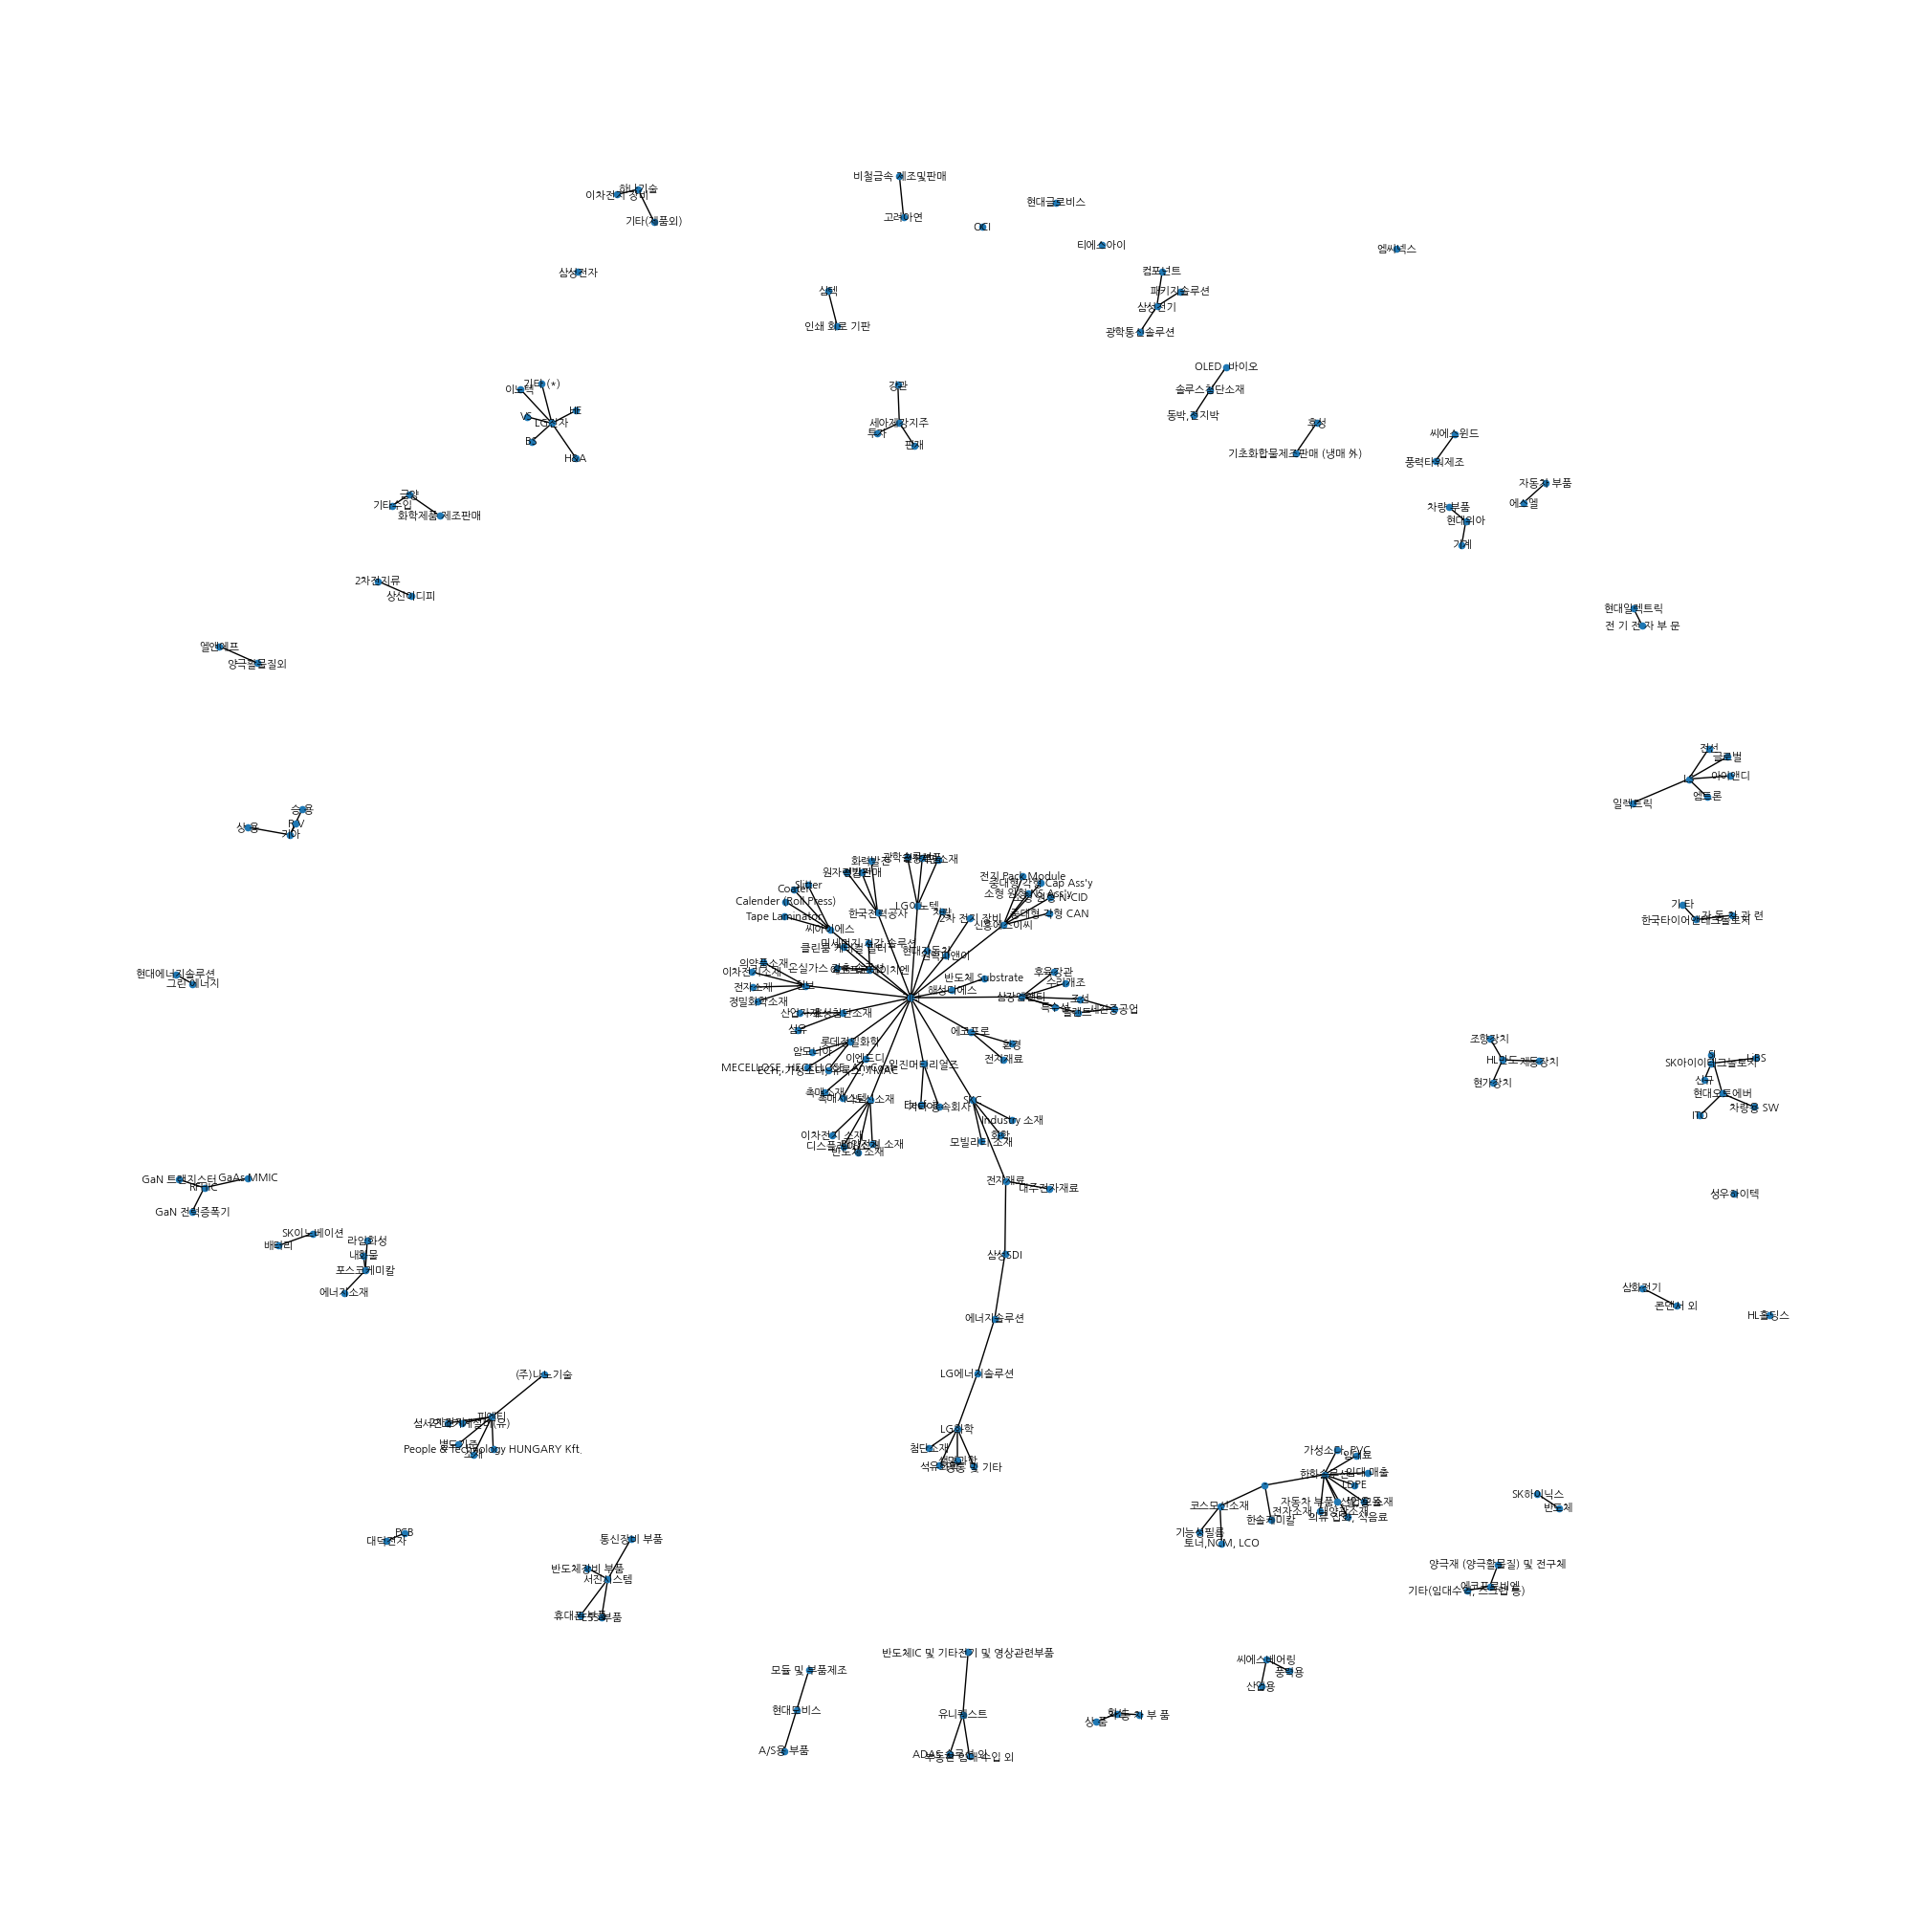

In [102]:
# 그려보기 
plt.figure(figsize=(20,20))
pos=nx.spring_layout(g)
nx.draw(g, pos, node_size=20)
nx.draw_networkx_labels(g,pos, font_family='NanumGothic', font_size=8)

In [103]:
data1

{'00897752': {'전자소재': ['LCD식각액첨가제'],
  '이차전지소재': ['전해액첨가제'],
  '의약품소재': ['의약품중간제'],
  '정밀화학소재': ['유리강화제'],
  '기타': ['용매제']},
 '00415628': {'조선': ['선 체', '선 실'], '플랜트': ['플랜트']},
 '00439965': {'디스플레이 소재': [],
  '반도체 소재': ['CMP slurry'],
  '태양전지 소재': [],
  '이차전지 소재': ['CNT'],
  '기타': ['TRB paste TCO target']},
 '00126362': {'에너지솔루션': ['소형전지'], '전자재료': ['EMC']},
 '00164779': {'반도체': ['DRAM', 'CIS', 'NAND Flash']},
 '00129271': {'콘덴서 외': ['전해콘덴서', '콘덴서 및 자재외', 'Green-Cap', '기타']},
 '01139035': {},
 '00106623': {'차량 부품': ['변속기', '등속조인트', '모듈부품', '소재', '엔진'],
  '기계': ['방산제품', '공작기계', '공장자동화 설비']},
 '01199550': {'그린 에너지': ['제어시스템', '태양광모듈', '용역수익 外']},
 '00106119': {'화학제품 제조판매': ['기 타', '발포제'], '기타수입': ['임대']},
 '00177816': {'전자재료': ['전도성 페이스트',
   '기타',
   '태양전지전극재료',
   '나노재료',
   '고분자재료',
   '기타제품',
   '형광체재료']},
 '00164742': {'차량': ['해외 완성차', '국내 완성차'], '기타': ['철도차량']},
 '00536541': {'환경': ['환경사업'],
  '전지재료': ['리튬분쇄 및 가공',
   '양극활물질용 전구체',
   '양극소재용 리튬 생산',
   '산업용 가스',
   '폐배터리 재활용',
   

In [104]:

data2['00106119']['ner']

[{('리튬배터리', 'TERM'),
  ('발포', 'TERM'),
  ('수산화리튬', 'MATERIAL'),
  ('수소연료전지', 'TERM'),
  ('원통형', 'TERM'),
  ('이차전지', 'TERM'),
  ('자동차', 'ARTIFACT'),
  ('전기차', 'ARTIFACT'),
  ('지르코늄', 'MATERIAL')},
 {('CELLCOM', 'ARTIFACT'),
  ('고무', 'MATERIAL'),
  ('발포', 'TERM'),
  ('발포제', 'TERM'),
  ('합성수지', 'MATERIAL')},
 {('경남', 'LOCATION'),
  ('김해', 'LOCATION'),
  ('발포', 'TERM'),
  ('부산', 'CITY'),
  ('중국', 'COUNTRY')},
 {('고객', 'CIVILIZATION')},
 set(),
 {('CHARLIZE RESSOURCES SAS 사', 'ORGANIZATION'),
  ('CHARLIZE RESSOURCES SAS사', 'ORGANIZATION'),
  ('리튬', 'MATERIAL'),
  ('리튬광산', 'LOCATION'),
  ('수소기술퀀텀센터', 'ARTIFACT'),
  ('콩고민주공화국', 'COUNTRY')}]

In [105]:
test = set()
for key, value in data2.items():
#     print(value['ner'][0])
    temp = {y[1] for x in value['ner'] for y in x}
    test = test.union(temp)
test

# 1. 사업의 개요
# 2. 주요 제품 및 서비스
# 3. 원재료 및 생산설비
# 4. 매출 및 수주상황
# 5. 위험관리 및 파생거래
# 6. 주요계약 및 연구개발활동 


# 주요 제품 (others), 관계사 (organization), 원재료 (material), 사업장 위치 (Location, city, country), 관련 이슈 (theory)
# 제외: animal, civilization, event, occupation, person, plant, time

{'ANIMAL',
 'ARTIFACT',
 'CITY',
 'CIVILIZATION',
 'COUNTRY',
 'DISEASE',
 'EVENT',
 'LOCATION',
 'MATERIAL',
 'OCCUPATION',
 'ORGANIZATION',
 'PERSON',
 'PLANT',
 'STUDY_FIELD',
 'TERM',
 'THEORY',
 'TIME'}

In [106]:
for key, value in data2.items():
    for x in value['ner']:
        for y in x:
            if y[1] == 'TIME':
                print(y)

('심야', 'TIME')
('1시간', 'TIME')
('24시간', 'TIME')
('8시간', 'TIME')


In [107]:
nx.write_gml(g, path="graph_test")

In [108]:
G_loaded = nx.read_gml(path='graph_test')
print(f"nodes: {G_loaded.nodes(data=True)}")
print(f"edges: {G_loaded.edges(data=True)}")

nodes: [('삼성SDI', {'kind': 'corporation'}), ('후성', {'kind': 'corporation'}), ('효성첨단소재', {'kind': 'corporation'}), ('화신', {'kind': 'corporation'}), ('현대자동차', {'kind': 'corporation'}), ('현대일렉트릭', {'kind': 'corporation'}), ('현대위아', {'kind': 'corporation'}), ('현대오토에버', {'kind': 'corporation'}), ('현대에너지솔루션', {'kind': 'corporation'}), ('현대모비스', {'kind': 'corporation'}), ('현대글로비스', {'kind': 'corporation'}), ('해성디에스', {'kind': 'corporation'}), ('한화솔루션', {'kind': 'corporation'}), ('한솔케미칼', {'kind': 'corporation'}), ('한국타이어앤테크놀로지', {'kind': 'corporation'}), ('한국전력공사', {'kind': 'corporation'}), ('하나기술', {'kind': 'corporation'}), ('피엔티', {'kind': 'corporation'}), ('포스코케미칼', {'kind': 'corporation'}), ('티에스아이', {'kind': 'corporation'}), ('코스모신소재', {'kind': 'corporation'}), ('천보', {'kind': 'corporation'}), ('일진머티리얼즈', {'kind': 'corporation'}), ('이엔드디', {'kind': 'corporation'}), ('유니퀘스트', {'kind': 'corporation'}), ('원익피앤이', {'kind': 'corporation'}), ('엠씨넥스', {'kind': 'corporation'}), ('엘앤에프', {'kind':

In [109]:
remove_list = [
    '(주)', '㈜', '(유)'
]

def preprocess_korean(x):
    for remove_word in remove_list:
        x = x.replace(remove_word,'')
    return x

In [110]:
for company_code in data2.keys():
    for l in data2[company_code]['ner']:
        if not l:
            continue
        for term, ner in l:
            term = preprocess_korean(term)

            # spelled_sent = spell_checker.check(term)
            # hanspell_sent = spelled_sent.checked   
            revised_term = spacing(term)
            if term != revised_term:
                print(f'변경 전: {term}')
                print(f'\t변경 후: {revised_term}')
    

변경 전: 상신EDP
	변경 후: 상신 EDP
변경 전: 에코프로
	변경 후: 에코 프로
변경 전: 유미코아
	변경 후: 유미 코아
변경 전: Bayerische Motoren Werke
	변경 후: Bayeris che Mot oren Werke
변경 전: 이차 전지
	변경 후: 이 차 전지
변경 전: 코로나19
	변경 후: 코로나 19
변경 전: 리튬2차전지
	변경 후: 리튬 2차전지
변경 전: Nylon
	변경 후: Nyl on
변경 전: 폴리에스터원사
	변경 후: 폴리에스터 원사
변경 전: 스판덱스원사
	변경 후: 스판덱스 원사
변경 전: 스판덱스원사
	변경 후: 스판덱스 원사
변경 전: 항저우일천화학
	변경 후: 항저우일 천화학
변경 전: 강소항력화섬 주식회사
	변경 후: 강 소항력화 섬 주식회사
변경 전: 효성티앤씨
	변경 후: 효성 티앤씨
변경 전: Nylon Yarn
	변경 후: Nyl on Yarn
변경 전: Invista
	변경 후: Inv ista
변경 전: Nylon
	변경 후: Nyl on
변경 전: Hyosung DongNai
	변경 후: Hyosu ng DongNai
변경 전: 나일론필름
	변경 후: 나일론 필름
변경 전: 청도강철
	변경 후: 청도 강철
변경 전: 나일론필름
	변경 후: 나일론 필름
변경 전: 정부보조금
	변경 후: 정부 보조금
변경 전: 인도공장
	변경 후: 인도 공장
변경 전: 체코공장
	변경 후: 체코 공장
변경 전: 러시아공장
	변경 후: 러시아 공장
변경 전: 튀르키예공장
	변경 후: 튀르키 예공장
변경 전: 베트남공장
	변경 후: 베트남 공장
변경 전: 미국공장
	변경 후: 미국 공장
변경 전: 현대캐피탈현대캐피탈
	변경 후: 현대캐피탈 현대캐피탈
변경 전: 고압차단기
	변경 후: 고압 차단기
변경 전: 중저압차단기
	변경 후: 중저압 차단기
변경 전: 주식회사대영기계
	변경 후: 주식회사 대영기계
변경 전: 현대중공(중국)전기유한공사
	변경 후: 현대중공(중국) 전기유한공사
변경 전: 현대중공(중국)전기

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import networkx as nx
import itertools
import community as community_louvain
import json
from pyvis.network import Network
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go


data1_path = '/home/kic/data/dart_processed/dict_sector_product_processed.pickle'
data2_path = '/home/kic/data/dart_processed/html_EV_v2.pickle'
ev_list_path = '/home/kic/data/kodex/EV_processed.csv'

with open(data1_path, 'rb') as f:
    data1 = pickle.load(f)

with open(data2_path, 'rb') as f:
    data2 = pickle.load(f)

ev_list = pd.read_csv(ev_list_path, dtype=object)

g = nx.Graph()

corp_name = []
for key in data2.keys():
    corp_name.append(data2[key]['corp_name'])
g.add_nodes_from(corp_name, kind='corporation')

주요제품_level1 = []
for key in data2.keys():
    주요제품_level1 += [product for product in data1[key]]

g.add_nodes_from(주요제품_level1, kind='주요제품')

for key in data2.keys():
    주요제품_level1_temp = [product for product in data1[key]]
    회사명 = data2[key]['corp_name']
    edges = [(회사명, product) for product in 주요제품_level1_temp]
    g.add_edges_from(edges, kind='주요제품')

{'삼성SDI': Text(0.10740269863419677, -0.28995675197054727, '삼성SDI'),
 '후성': Text(-0.9050299977629943, 0.28368279036982574, '후성'),
 '효성첨단소재': Text(-0.5864950444106495, -0.5454836921578414, '효성첨단소재'),
 '화신': Text(-0.7397005461027167, 0.07961226781587141, '화신'),
 '현대자동차': Text(-0.4126402911237047, 0.7136540527380323, '현대자동차'),
 '현대일렉트릭': Text(0.561282427887563, 0.7755208939956613, '현대일렉트릭'),
 '현대위아': Text(0.7454194193487977, -0.3525908357247963, '현대위아'),
 '현대오토에버': Text(0.6982126338658122, 0.3008763973520639, '현대오토에버'),
 '현대에너지솔루션': Text(0.8282185266486691, -0.48074391347998224, '현대에너지솔루션'),
 '현대모비스': Text(-0.14979126552893066, -0.792642858697067, '현대모비스'),
 '현대글로비스': Text(-0.5157115936475181, 0.8158546344553409, '현대글로비스'),
 '해성디에스': Text(-0.8751364562558537, 0.4344304225479261, '해성디에스'),
 '한화솔루션': Text(-0.1568672304833508, 0.013507491561493242, '한화솔루션'),
 '한솔케미칼': Text(0.4190997697851426, 0.8960587425067364, '한솔케미칼'),
 '한국타이어앤테크놀로지': Text(0.20705333390828745, 0.9370725121928035, '한국타이어앤테크

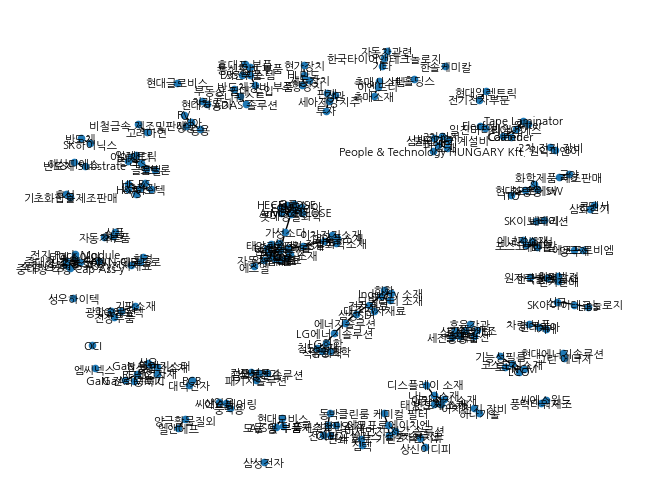

In [ ]:
pos=nx.spring_layout(g)
nx.draw(g, pos, node_size=20)
nx.draw_networkx_labels(g,pos, font_family='NanumGothic', font_size=8)

In [ ]:
G= g

In [ ]:
pos = nx.spring_layout(G)


In [ ]:
pos

{'삼성SDI': array([-0.1932176 ,  0.26495748]),
 '후성': array([-0.54018761,  0.62599409]),
 '효성첨단소재': array([-0.03665665, -0.80636116]),
 '화신': array([-0.67755127, -0.29895999]),
 '현대자동차': array([ 0.64102872, -0.59166359]),
 '현대일렉트릭': array([-0.50356485, -0.9186296 ]),
 '현대위아': array([ 0.21619536, -0.089017  ]),
 '현대오토에버': array([0.34769096, 0.82535014]),
 '현대에너지솔루션': array([ 0.80487266, -0.37037807]),
 '현대모비스': array([0.89669654, 0.05142984]),
 '현대글로비스': array([ 0.42912323, -0.91426616]),
 '해성디에스': array([ 0.23580273, -0.83221996]),
 '한화솔루션': array([-0.36419397, -0.0546533 ]),
 '한솔케미칼': array([0.75985271, 0.76116088]),
 '한국타이어앤테크놀로지': array([-0.06003238, -0.88748713]),
 '한국전력공사': array([ 0.39514492, -0.68227061]),
 '하나기술': array([ 0.07012509, -0.77271421]),
 '피엔티': array([ 0.42254993, -0.28030306]),
 '포스코케미칼': array([ 0.25449191, -0.7184243 ]),
 '티에스아이': array([0.66030663, 0.70914489]),
 '코스모신소재': array([-0.42047167,  0.71614942]),
 '천보': array([-0.35511295,  0.11364582]),
 '일진머티리얼즈': arr

In [ ]:
edge_x = []
edge_y = []
for edge in G.edges():
    # x0, y0 = G.nodes[edge[0]]['pos']
    # x1, y1 = G.nodes[edge[1]]['pos']
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

In [ ]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [ ]:
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

In [ ]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    print(adjacencies)
    node_adjacencies.append(len(adjacencies[1]))
    # node_text.append('# of connections: '+str(len(adjacencies[1])))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

('삼성SDI', {'에너지솔루션': {'kind': '주요제품'}, '전자재료': {'kind': '주요제품'}})
('후성', {'기초화합물제조판매': {'kind': '주요제품'}})
('효성첨단소재', {'산업자재': {'kind': '주요제품'}, '섬유': {'kind': '주요제품'}})
('화신', {'자동차부품': {'kind': '주요제품'}, '상품': {'kind': '주요제품'}})
('현대자동차', {'차량': {'kind': '주요제품'}})
('현대일렉트릭', {'전기전자부문': {'kind': '주요제품'}})
('현대위아', {'차량 부품': {'kind': '주요제품'}, '기계': {'kind': '주요제품'}})
('현대오토에버', {'ITO': {'kind': '주요제품'}, 'SI': {'kind': '주요제품'}, '차량용 SW': {'kind': '주요제품'}})
('현대에너지솔루션', {'그린 에너지': {'kind': '주요제품'}})
('현대모비스', {'모듈 및 부품제조': {'kind': '주요제품'}, 'A/S용 부품': {'kind': '주요제품'}})
('현대글로비스', {})
('해성디에스', {'반도체 Substrate': {'kind': '주요제품'}})
('한화솔루션', {'LDPE': {'kind': '주요제품'}, '가성소다': {'kind': '주요제품'}, 'PVC': {'kind': '주요제품'}, '임대료': {'kind': '주요제품'}, '자동차 부품': {'kind': '주요제품'}, '산업용 소재': {'kind': '주요제품'}, '전자소재': {'kind': '주요제품'}, '태양광소재': {'kind': '주요제품'}, '의류 잡화': {'kind': '주요제품'}, '식음료': {'kind': '주요제품'}, '임대 매출': {'kind': '주요제품'}, '셀': {'kind': '주요제품'}, '모듈': {'kind': '주요제품'}})
('한솔케미칼', {})
('

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()